In [1]:
%%capture
from tqdm.notebook import tqdm

import pickle
import json
import os
import numpy as np
import matplotlib.pyplot as plt

random_seed = 42
np.random.seed(random_seed)

import tensorflow as tf
tf.random.set_seed(random_seed)
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

binary_vectors_size = 8477

data_dir = 'data/'
preproc_path = data_dir + 'preprocessed/8477_vec_size/'

binary_path = preproc_path + 'binary/'
train_binary_path = binary_path + 'train/'
test_binary_path = binary_path + 'test/'

benign_dir = 'benign/'
malicious_dir = 'malicious/'

encoder_path = preproc_path + 'encoder/'
train_encoder_path = encoder_path + 'train/'
test_encoder_path = encoder_path + 'test/'

models_path = 'models/'

if not os.path.isdir(models_path):
    os.makedirs(models_path)

Get unique vectors for unsupervised learning

In [2]:
def get_unique_binary_patterns(dir_path):
    uniq_binary_patterns = set()

    filenames = [dir_path + label + filename for label in [benign_dir, malicious_dir] for filename in os.listdir(dir_path + label)]

    for filename in filenames:
        vec_log = np.load(filename)
        for vec in vec_log:
            uniq_binary_patterns.add(vec.tostring())
    
    return uniq_binary_patterns #[np.frombuffer(vec,dtype=np.int8) for vec in uniq_binary_patterns]

In [7]:
def prepare_encoder_dataset():
    train_binary_patterns = get_unique_binary_patterns(train_binary_path)
    test_binary_patterns = get_unique_binary_patterns(test_binary_path)
    
    print(len(train_binary_patterns), len(test_binary_patterns), len(train_binary_patterns - test_binary_patterns))
    train_binary_patterns = train_binary_patterns - test_binary_patterns
    X_train = np.stack([np.frombuffer(vec,dtype=np.int8) for vec in train_binary_patterns])
    X_test = np.stack([np.frombuffer(vec,dtype=np.int8) for vec in test_binary_patterns])
    print(X_train.shape, X_test.shape)

    if not os.path.isdir(train_encoder_path):
        os.makedirs(train_encoder_path)

    if not os.path.isdir(test_encoder_path):
        os.makedirs(test_encoder_path)

    np.save(encoder_path + 'train.npy', X_train.astype(np.float))
    np.save(encoder_path + 'test.npy', X_test.astype(np.float))

In [8]:
prepare_encoder_dataset()
#with open(encoder_path + 'partition.pkl', 'wb') as out_file:
#    pickle.dump(partition, out_file)

144216 44220 129099
(129099, 8477) (44220, 8477)


In [2]:
def load_dataset(dir_path):
    X = np.load(dir_path)
    return X

In [3]:
print('Loading autoencoder datasets')
X_train = load_dataset(encoder_path + 'train.npy')
X_test = load_dataset(encoder_path + 'test.npy')

indices = np.random.permutation(len(X_train))
train_size = len(indices) * 8 // 10
X_valid = X_train[indices[train_size:]]
X_train = X_train[indices[:train_size]]

noise_factor = 0.2
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_valid_noisy = X_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_valid.shape) 
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_valid_noisy = np.clip(X_valid_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

Loading autoencoder datasets


In [28]:
X_test = 0
X_test_noisy = 0

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.constraints import non_neg
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
def get_autoencoder(layer_sizes, dropout, optimizer, regularization):
    inp = Input(shape=(binary_vectors_size,))
    encoded = Dense(layer_sizes[0], kernel_constraint=non_neg(), activation='relu')(inp)
    
    for layer_size in layer_sizes[1:]:
        encoded = Dropout(dropout)(encoded)
        encoded = Dense(layer_size, kernel_constraint=non_neg(), activation='relu')(encoded)
        
    #encoded = Dropout(dropout)(encoded)
    #encoded = Dense(layer_sizes[-1], kernel_constraint=non_neg(), activation='relu')(encoded)#, activity_regularizer=regularizers.l1(regularization)
        
    decoded = Dense(layer_sizes[-2], activation='relu')(encoded)
    for layer_size in reversed(layer_sizes[:-2]):
        decoded = Dropout(dropout)(decoded)
        decoded = Dense(layer_size, activation='relu')(decoded)

    decoded = Dropout(dropout)(decoded)
    decoded = Dense(binary_vectors_size, activation='sigmoid')(decoded)
    
    encoder = Model(inputs=inp, outputs=encoded)
    autoencoder = Model(inputs=inp, outputs=decoded)
    autoencoder.compile(optimizer=optimizer_name, loss='binary_crossentropy')
    
    return autoencoder, encoder

def get_next_sae(inp_dim, hid_dim):
    inp = Input(shape=(inp_dim,))
    encoded = Dense(hid_dim, activation='relu', activity_regularizer=regularizers.l1(10))(inp)#
    decoded = Dropout(0.5)(encoded)
    decoded = Dense(inp_dim, activation='sigmoid')(decoded)   
    encoder = Model(inputs=inp, outputs=encoded)
    autoencoder = Model(inputs=inp, outputs=decoded)
    opt = Adam()#learning_rate=0.01)
    autoencoder.compile(loss='binary_crossentropy',
                    optimizer=opt)
    return autoencoder, encoder
    

In [29]:
auto_enc, encoder_ = get_next_sae(binary_vectors_size, 4096)
auto_enc.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 8477)]            0         
_________________________________________________________________
dense_12 (Dense)             (None, 4096)              34725888  
_________________________________________________________________
dropout_6 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 8477)              34730269  
Total params: 69,456,157
Trainable params: 69,456,157
Non-trainable params: 0
_________________________________________________________________


In [32]:
auto_enc.save('{}autoencoder_1.h5'.format(models_path))
encoder_1.save('{}encoder_1.h5'.format(models_path))

In [ ]:
X_train_1 = encoder_1.predict(X_train)

X_train_1_n = X_train_1 + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train_1.shape)

X_train_1_n = np.clip(X_train_1_n, 0., 1.)

auto_enc, encoder_2 = get_next_sae(4096, 1024)
auto_enc.summary()

In [31]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

batch_size = 512
epochs = 100
history = auto_enc.fit(X_train_noisy, X_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(X_valid_noisy, X_valid), callbacks=[es])

Epoch 1/100
101/101 [==============================] - 14s 141ms/step - loss: 0.0160 - val_loss: 0.0160
Epoch 2/100
101/101 [==============================] - 15s 148ms/step - loss: 0.0159 - val_loss: 0.0159
Epoch 3/100
101/101 [==============================] - 15s 146ms/step - loss: 0.0157 - val_loss: 0.0158
Epoch 4/100
101/101 [==============================] - 14s 138ms/step - loss: 0.0156 - val_loss: 0.0156
Epoch 5/100
101/101 [==============================] - 14s 140ms/step - loss: 0.0155 - val_loss: 0.0155
Epoch 6/100
101/101 [==============================] - 15s 146ms/step - loss: 0.0154 - val_loss: 0.0154
Epoch 7/100
101/101 [==============================] - 14s 141ms/step - loss: 0.0153 - val_loss: 0.0153
Epoch 8/100
101/101 [==============================] - 14s 141ms/step - loss: 0.0152 - val_loss: 0.0152
Epoch 9/100
101/101 [==============================] - 14s 140ms/step - loss: 0.0151 - val_loss: 0.0151
Epoch 10/100
101/101 [==============================] - 18s 179m

In [6]:
optimizer_name = 'adam'
layer_sizes = [2**n for n in range(11, 4, -1)]
dropout = 0.4
batch_size = 64
epochs = 200
regularization=10e-4

autoencoder, encoder = get_autoencoder(layer_sizes, dropout, optimizer_name, regularization)
autoencoder.summary()
encoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 8477)]            0         
_________________________________________________________________
dense_14 (Dense)             (None, 2048)              17362944  
_________________________________________________________________
dropout_12 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_13 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0   

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(X_valid, X_valid), callbacks=[es])

test_loss = autoencoder.evaluate(X_test, X_test)

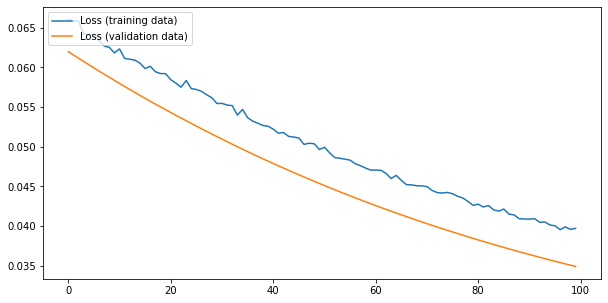

<Figure size 432x288 with 0 Axes>

In [35]:
run_name_suff = '_lss{:.4e}_dim{}_hls{}_ils{}_bs{}_e{}_need_train_more_reg{:.3e}_drp{}_opt{}'.format(test_loss, binary_vectors_size, layer_sizes[-1], layer_sizes[0], 
                                                                                     batch_size, epochs, regularization, dropout, optimizer_name)
autoencoder.save('{}autoencoder{}.h5'.format(models_path, run_name_suff))
encoder.save('{}encoder{}.h5'.format(models_path, run_name_suff))

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.legend(loc="upper left")
plt.show()
plt.savefig('{}autoencoder{}.png'.format(models_path, run_name_suff))

In [34]:
hiden_preds = encoder.predict(X_test)

print(hiden_preds.shape, np.min(hiden_preds), np.max(hiden_preds), np.mean(hiden_preds))

(34661, 32) 0.0 44030.883 23.47358
